<!--NAVIGATION-->
< [6_Hazard_Mapping Python_GDA](6_Hazard_Mapping Python_GDAL.ipynb) | [Contents](Index.ipynb) | [7_Risk_Mapping Python_GDAL](7_Risk_Mapping Python_GDAL.ipynb) >

<img align="left" style="width: 350px;" src="figures/logo.png"/>
----------------------------------------------------------------------------------------------------------------------
# Bologna Training Course 23 – 27 January 2017

# Hydrological and Flood Risk Geo-processing with Open Source (Python/GDAL) 
<img  align="left" style="width: 300px;" src="figures/logo2011.jpg"/>

----------------------------------------------------------------------------------------------------------------------
## Stefano Bagli and Paolo Mazzoli - [GECOsistema srl ](www.gecosistema.com)
----------------------------------------------------------------------------------------------------------------------

#  6 Hazard Mapping with Python/GDAL - Raster Dem Flooding

This tutorial illustrates how to generate a flood hazard maps with a simplified raster-based inundation model

**Geospatial models are a powerful tool in estimating the impact of a flood and mitigating that impact before it happens.**
We often hear in the news that a river is reaching flood stage. But that information is meaningless if we can't understand the actual impact. 
- Fully numerical Hydrological flood models are expensive to develop and can be very complex. These models are essential for engineers building flood control systems. 
- However, first responders and potential flood victims are only interested to know about the impact of an impending flood.
We can understand the flooding impact in an area using a very simple and easy-to-comprehend tool called a flood inundation model. 

This model starts with a single point and floods an area with the maximum volume of water that a flood basin can hold at a particular flood stage. Usually this analysis is the worst-case scenario. It assumes a INFINITE Volume of Water displaced by river/storm surges over the floodplain.
Hundreds of other factors go into calculating how much water will enter into a basin from a river topping flood stage. But, we can still learn a lot from this simple first-order model.


The following image is a Digital Elevation Model (DEM) with a source point displayed as a yellow star near Torino, Italy. In real-world analysis, this point would likely be a stream gauge where you would have data about the river's
water level.

The algorithm we are introducing in this example is called a **flood fill algorithm**, which is not really surprising. 

<p><a href="https://commons.wikimedia.org/wiki/File:Recursive_Flood_Fill_4_(aka).gif#/media/File:Recursive_Flood_Fill_4_(aka).gif"><img src="https://upload.wikimedia.org/wikipedia/commons/7/7e/Recursive_Flood_Fill_4_%28aka%29.gif" alt="Recursive Flood Fill 4 (aka).gif"></a><br>By André Karwath aka <a href="//commons.wikimedia.org/wiki/User:Aka" title="User:Aka">Aka</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/2.5" title="Creative Commons Attribution-Share Alike 2.5">CC BY-SA 2.5</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=481651">Link</a></p>


The flood-fill algorithm takes three parameters: a start node, a target color/elevetation, and a replacement color/flood id (0 non flooded 1 flooded). 
The algorithm looks for all nodes in the array that are connected to the start node by a path of the target color and changes them to the replacement color. There are many ways in which the flood-fill algorithm can be structured, but they all make use of a queue or stack data structure, explicitly or implicitly.

Depending on whether we consider nodes touching at the corners connected or not, we have two variations: eight-way and four-way respectively.

This algorithm is well known in the field of Computer Science and is used in the classic computer game Mine Sweeper to clear empty squares on the board when a user clicks on a square. It is also the method used for the well-known paint bucket tool in graphics programs such as Adobe Photoshop, where the paint bucket is used to fill an area of adjacent pixels of the same color with a different color. 
There are many ways to implement this algorithm. One of the oldest and most common ways is to recursively crawl through each pixel of the image. The problem with recursion is that you end up processing pixels more than once and then creating an unnecessary amount of work. The resource usage for a
recursive flood fill can easily crash a program on even a moderately-sized image.
This script uses a four-way queue-based flood fill that may visit a cell more than once but ensures we only process a cell once. The queue contains unique, unprocessed cells by using Python's built-in set type, which only holds unique values. We use two sets called fill that contain the cells we need to fill, and filled that
contain processed cells.

The flood fill algorithm is a method of determining connected regions in an array (e.g. for filling an area of pixels with a colour).
## 6.1 Pseudo code
Flood-fill (node, target-color, replacement-color):
 1. If the color of node is not equal to target-color, return.
 2. Set the color of node to replacement-color.
 3. Perform Flood-fill (one step to the west of node, target-color, replacement-color).
    Perform Flood-fill (one step to the east of node, target-color, replacement-color).
    Perform Flood-fill (one step to the north of node, target-color, replacement-color).
    Perform Flood-fill (one step to the south of node, target-color, replacement-color).
 4. Return.



##  6.2 Inundation scenarios Tourin Area (water level above ground level in [m])

For each inundation scenario (11, 11.5, 12, 12.5 m) the next script compute the hazard map

In [1]:
import gdal,gdalconst
import numpy
import os, glob
import sys
import matplotlib.pyplot as plt
from osgeo import ogr, osr
import csv
#-------------------------------------------------------------------------------
#   GDAL2Numpy
#-------------------------------------------------------------------------------
def GDAL2Numpy(pathname):
    dataset = gdal.Open(pathname,gdalconst.GA_ReadOnly) # open the dataset in read mode
    band = dataset.GetRasterBand(1) # get the first band (Remember that band indices start at 1 instead of 0 )
    cols = dataset.RasterXSize # read number of colums
    rows = dataset.RasterYSize # read number of rows
    geotransform = dataset.GetGeoTransform() # read the geotransform (origin coordinates and pixel sizes, along with rotation values)
    projection = dataset.GetProjection() # read the proj info
    wdata = band.ReadAsArray(0, 0, cols, rows).astype("float32") #read all pixels as array
    nodata =band.GetNoDataValue()
    return (wdata,geotransform,projection,nodata) 
#-------------------------------------------------------------------------------
#   Numpy2GTiff
#-------------------------------------------------------------------------------
def Numpy2GTiff(arr ,geotransform,projection,filename):
    if isinstance(arr,numpy.ndarray):
        rows,cols = arr.shape
        if rows>0 and cols>0:
            dtype = str(arr.dtype)
            if   dtype in ["uint8"]:
                fmt = gdal.GDT_Byte
            elif dtype in ["uint16"]:
                fmt = gdal.GDT_UInt16
            elif dtype in ["uint32"]:
                fmt = gdal.GDT_UInt32
            elif dtype in ["float32"]:
                fmt = gdal.GDT_Float32
            elif dtype in ["float64"]:
                fmt = gdal.GDT_Float64
            else:
                fmt = gdal.GDT_Float64

            driver = gdal.GetDriverByName("GTiff")
            dataset = driver.Create( filename, cols, rows, 1, fmt )
            if (geotransform!=None):
                dataset.SetGeoTransform( geotransform )
            if (projection!=None):
                dataset.SetProjection(projection)
            dataset.GetRasterBand(1).WriteArray( arr )
            dataset = None
            return filename
    return None

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Opening image...
250
Image opened
Image masked

4130000.0
2435000.0
Beginning flood fill
Finished Flood fill
Compute Water Depth
Saving grid


<IPython.core.display.Javascript object>


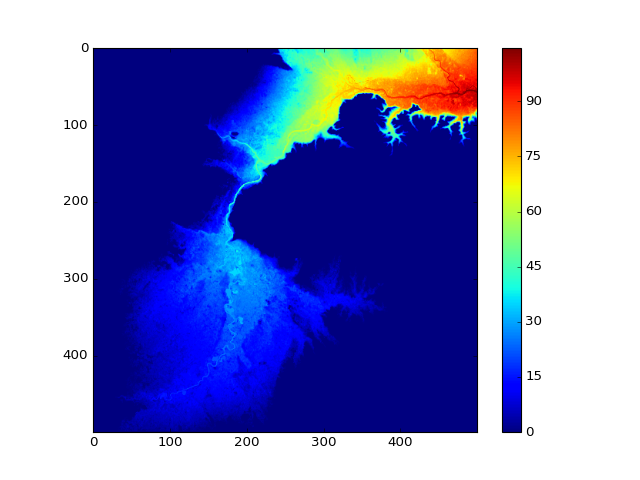

<IPython.core.display.Javascript object>


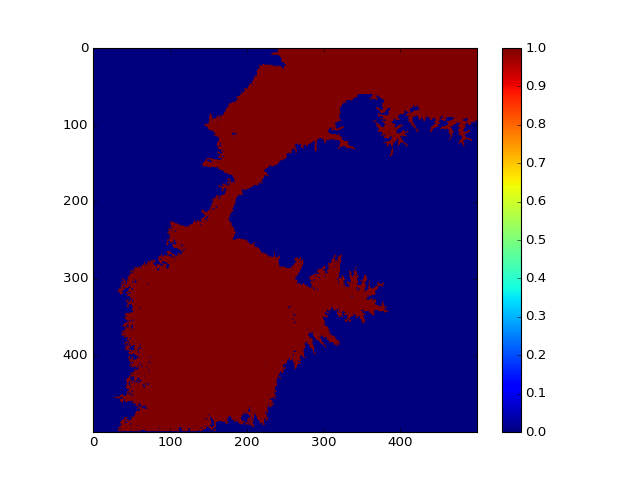

In [2]:
"""
Crawls a terrain raster from a starting
point and "floods" everything at the same
or lower elevation by producing a mask
image of 1, 0 values.
"""
##This example executes the following steps:
#2. Open the DEM as a numpy array.
#3. Define our starting point as row and column in the array.
#4. Declare a flood elevation value.
#5. Filter the terrain to only the desired elevation value and below.
#6. Process the filtered array.
#7. Create a (1, 0) array (that is, binary array) with flooded pixels as 1.
#8. Save the flood inundation array as TIFF Grid.


import numpy as np
from linecache import getline


def floodFill(c, r, mask):
    """
    Crawls a mask array containing
    only 1 and 0 values from the
    starting point (c=column,
    r=row - a.k.a. x, y) and returns
    an array with all 1 values
    connected to the starting cell.
    This algorithm performs a 4-way
    check non-recursively.
    """
    # cells already filled
    filled = set()
    # cells to fill
    fill = set()
    fill.add((c, r))
    width = mask.shape[1]-1
    height = mask.shape[0]-1
    # Our output inundation array
    flood = np.zeros_like(mask, dtype=np.int8)
    # Loop through and modify the cells which
    # need to be checked.
    
    while fill:
        # Grab a cell
        x, y = fill.pop()
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
        if mask[y][x] == 1:
            # Do fill
            flood[y][x] = 1
            filled.add((x, y))
            # Check neighbors for 1 values
            west = (x-1, y)
            east = (x+1, y)
            north = (x, y-1)
            south = (x, y+1)
            if west not in filled:
                fill.add(west)
            if east not in filled:
                fill.add(east)
            if north not in filled:
                fill.add(north)
            if south not in filled:
                fill.add(south)
    return flood

#source = "/Users/stepaly/GdriveGECO/my_work/25_R&D_SYSTE_IDR_02102015_S/GIS_Python_Course/FloodFill/terrain.asc"
workdir='data/Chap_6/'
workoutdir='data/Chap_6/output/'
source = workdir+'eu_dem_v11_E40N20_Turim.tif'


#target = "/Users/stepaly/GdriveGECO/my_work/25_R&D_SYSTE_IDR_02102015_S/GIS_Python_Course/FloodFill/flood.asc"
flood_map = workoutdir+"flood.tif"
wd_map = workoutdir+"wd.tif"



print("Opening image...")
(dem, geotransform, projection,nodata)=GDAL2Numpy(source)

xmin=geotransform[0]
pixel_size=geotransform[1]
ymax=geotransform[3]
rows,cols=np.shape(dem)
ymin=ymax-pixel_size*rows


dem=dem.astype(int)

# Starting point for the
# flood inundation
sx = 100
sy = 250
sh=dem[sy,sx]
print sh

#img = np.loadtxt(source, skiprows=6)
print("Image opened")
water_stage=sh+0.5

a = np.where(dem < water_stage, 1, 0)
print("Image masked")



print 
xsource=(sx*pixel_size)+xmin
ysource=ymin+(sy*pixel_size)
print xsource
print ysource

print("Beginning flood fill")
fld = floodFill(sx, sy, a)
print("Finished Flood fill")

print("Compute Water Depth")
wd=np.where(fld*water_stage-dem<0,0,fld*water_stage-dem)

print("Saving grid")

Numpy2GTiff(fld ,geotransform,projection,flood_map)
Numpy2GTiff(wd ,geotransform,projection,wd_map)

%matplotlib notebook
plt.figure()
plt.imshow(wd)
plt.colorbar()

plt.figure()
plt.imshow(fld)
plt.colorbar()

In [ ]:
xsource
ysource

<!--NAVIGATION-->
< [6_Hazard_Mapping Python_GDA](6_Hazard_Mapping Python_GDAL.ipynb) | [Contents](Index.ipynb) | [7_Risk_Mapping Python_GDAL](7_Risk_Mapping Python_GDAL.ipynb) >